# SABR calibration in Python

Ce projet a pour but de faire le calibrage du modele SABR pour le pricing des swaption.
### Introduction:
Les options dites europeennes sont evaluées et couvertes par le fameux modele de Black and Scholes. La reproche faite à ce modele est le fait que l'un des paramettre(Volatilité) ne soit pas observable sur le marché. De facon thérioque ce paramettre est constant dans le modele et est obtenu de facon implicite en utilisation le prix correspondant d'option sur le marché. 

Donc pour diffenrentes options, il faut chacune differentes volatilités et cela rend tres difficile le regroupement pour une gestion de risque en portefeuille d'options.

Le modele SABR a été devolopper pour repondre à cette question. Cela consiste à prendre deux dynamiques difference correlées pour l'option et la volatilités.

Nous nous referons ici aux travaux de **Giovanni Travaglini** pour calibrer et implementer le modele.

#  Importation des libraries

In [1]:
import xlrd
import math
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Fonction definitions

Ici, nous implementtons les differentes fonctions implémentées par **Giovanni Travaglini** Pour le calibrage.

### La fonction SABR

Elle de calculer la difference de valeur entre la volatilité du marché et celle derivée du modele pour toutes les maturté

In [2]:
def SABR(alpha,beta,rho,nu,F,K,time,MKT): # all variables are scalars

    if K <= 0:   # negative rates' problem, need to shift the smile
        VOL = 0
        diff = 0
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (alpha/V)*A
        diff = VOL - MKT
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (nu*logFK*A)/(x*B)
        diff = VOL - MKT

    print(round(VOL,4)) ,  '\t' ,
    outvol.write('%r;' %round(VOL,4) )
    if MKT==0:
        diff = 0
        vol_diff.write('%s;' %'No market data')
    else:
        vol_diff.write('%r;' %round(diff,4) )

### La fonction SABR 1
Elle est une modification de la premiere pour retourner la valeur de la volatilité pour les paramettre donnés. Elle nous permettre d'avoir la variation de la volatilité selon chaque paramettre.

In [3]:
def SABR1(alpha,beta,rho,nu,F,K,time): # all variables are scalars

    if K <= 0:   # negative rates' problem, need to shift the smile
        VOL = 0
        diff = 0
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (alpha/V)*A
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        VOL = (nu*logFK*A)/(x*B)
    return VOL

### La fonction smile

Elle retourne la volatilité pour plusieurs valeurs du strike K

In [4]:
def smile(alpha,beta,rho,nu,F,K,time,MKT,i): # F, time and the parameters are scalars, K and MKT are vectors, i is the index for tenor/expiry label

    print (label_ten[i] , '\t' , label_exp[i] , '\t' ,)
    outvol.write('%s;%s;' %(label_ten[i],label_exp[i]))
    vol_diff.write('%s;%s;' %(label_ten[i],label_exp[i]))
    parameters.write('%s;%s;' %(label_ten[i],label_exp[i]))

    for j in range(len(K)):
        if K[0] <= 0:
            shift(F,K)
        SABR(alpha,beta,rho,nu,F,K[j],time,MKT[j])

    print (' ')
    outvol.write('\n')
    vol_diff.write('\n')
    parameters.write('%f;%f;%f;%f;' %(alpha ,beta ,rho ,nu))
    parameters.write('\n')

### La fonction SABR_matrix 

Nous retourne les differends output apres calibrage.

In [5]:
def SABR_vol_matrix(alpha,beta,rho,nu,F,K,time,MKT): # F, time and the parameters are vectors, K and MKT are matrices

    print (' ')
    print ('                                        '+'SABR VOLATILITIES')
    print ('  ' , '\t' , 'strikes:' , )
    for i in range(num_strikes):
        print (label_strikes[i] , '\t') 
    print (' ')
    outvol.write('%s;' %'SABR VOLATILITIES')
    outvol.write('\n')
    vol_diff.write('%s;' %'VOLATILITY DIFFERENCES')
    vol_diff.write('\n')
    parameters.write('%s;' %'PARAMETERS')
    parameters.write('\n')
    outvol.write('%s;%s;' %(' ','strikes:'))
    vol_diff.write('%s;%s;' %(' ','strikes:'))
    for j in range(len(strike_spreads)):
        outvol.write('%s;' %label_strikes[j])
        vol_diff.write('%s;' %label_strikes[j])
    outvol.write('\n')
    vol_diff.write('\n')
    print ('tenor' , '\t' ,   'expiry')
    parameters.write('%s;%s;%s;%s;%s;%s' %('tenor','expiry','alpha','beta','rho','nu'))
    parameters.write('\n')

    for i in range(len(F)):
        smile(alpha[i],beta[i],rho[i],nu[i],F[i],K[i],time[i],MKT[i],i)


### La fonction Shift

Elle s'assure que le strike K ne devienne negative suite à une valeur null du forward.

In [6]:
def shift(F,K):
    shift = 0.001 - K[0]
    for j in range(len(K)):
        K[j] = K[j] + shift
        F = F + shift   


### Objfunc 

Elle est la fonction objectif pour le calibrage du modele avec les données du marché.

In [7]:
def objfunc(par,F,K,time,MKT):
    sum_sq_diff = 0
    if K[0]<=0:
        shift(F,K)
    for j in range(len(K)):
        if MKT[j] == 0:   
            diff = 0       
        elif F == K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)
            VOL = (par[0]/V)*A
            diff = VOL - MKT[j]
        elif F != K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            z = (par[3]/par[0])*V*logFK
            x = math.log( ( math.sqrt(1-2*par[2]*z+z**2) + z - par[2] ) / (1-par[2]) )
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)
            VOL = (par[3]*logFK*A)/(x*B)
            diff = VOL - MKT[j]  
        sum_sq_diff = sum_sq_diff + diff**2  
        obj = math.sqrt(sum_sq_diff)
    return obj

In [8]:
def calibration(starting_par,F,K,time,MKT):
    for i in range(len(F)):
        x0 = starting_par
        bnds = ( (0.001,None) , (0,1) , (-0.999,0.999) , (0.001,None)  )
        res = minimize(objfunc, x0 , (F[i],K[i],time[i],MKT[i]) ,bounds = bnds, method='SLSQP') # for a constrained minimization of multivariate scalar functions
        alpha[i] = res.x[0]
        beta[i] = res.x[1]
        rho[i] = res.x[2]
        nu[i] = res.x[3]

### Ouverture des fichiers excel pour les output du calibrage

In [91]:
outvol = open('outvol.csv', 'w')             # file output of volatilities
vol_diff = open('vol differences.csv', 'w')  # file output differences between SABR and Market volatilities
parameters = open('parameters.csv', 'w')     # file output parameters


### L'importation des données du marché

Le chemin pourra etre adapter à votre espace de travail.

In [33]:
Market_data =pd.read_excel('market_data.xlsx',skiprows=0)

In [92]:
Market_data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Market Volatilities for strike spreads in bps:,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Tenor,Expiry,Fwd,-150.0000,-100.0000,-50.0000,-25.0000,0.0000,25.0000,50.0000,100.0000,150.0000
1,2,0.25,0.010764,0.0000,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
2,2,0.5,0.011099,0.0000,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
3,2,0.75,0.011602,0.0000,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
4,2,1,0.012194,0.0000,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
5,2,2,0.016196,0.0000,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442
6,2,5,0.028436,0.4040,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870
7,2,10,0.033873,0.3026,0.2725,0.2510,0.2422,0.2343,0.2279,0.2228,0.2161,0.2128
8,5,0.25,0.016017,1.1870,0.6027,0.4655,0.4278,0.4030,0.3879,0.3789,0.3710,0.3725
9,5,0.5,0.016802,0.9568,0.5800,0.4661,0.4339,0.4125,0.3969,0.3888,0.3801,0.3785


In [35]:
Market_data=Market_data.drop(["Unnamed: 12"],axis=1)

In [36]:
Market_data.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Market Volatilities for strike spreads in bps:,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Tenor,Expiry,Fwd,-150.0000,-100.0000,-50.0000,-25.0000,0.0000,25.0000,50.0000,100.0000,150.0000
1,2,0.25,0.010764,0.0000,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
2,2,0.5,0.011099,0.0000,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
3,2,0.75,0.011602,0.0000,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
4,2,1,0.012194,0.0000,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
5,2,2,0.016196,0.0000,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442
6,2,5,0.028436,0.4040,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870
7,2,10,0.033873,0.3026,0.2725,0.2510,0.2422,0.2343,0.2279,0.2228,0.2161,0.2128
8,5,0.25,0.016017,1.1870,0.6027,0.4655,0.4278,0.4030,0.3879,0.3789,0.3710,0.3725
9,5,0.5,0.016802,0.9568,0.5800,0.4661,0.4339,0.4125,0.3969,0.3888,0.3801,0.3785


# Affectation des données

### strike

In [37]:
strike_spreads=[]
strike_spreads=Market_data.iloc[0,3:]
num_strikes = len(strike_spreads)

In [38]:
strike_spreads=strike_spreads.values

In [39]:
strike_spreads,num_strikes

(array([-150.0, -100.0, -50.0, -25.0, 0.0, 25.0, 50.0, 100.0, 150.0],
       dtype=object),
 9)

### Expiries

In [40]:
expiries=[]
expiries=Market_data.iloc[1:,1].values

In [41]:
expiries

array([0.25, 0.5, 0.75, 1, 2, 5, 10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 0.25,
       0.5, 0.75, 1, 2, 5, 10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 0.25, 0.5,
       0.75, 1, 2, 5, 10, 2.2], dtype=object)

### fowards maturities

In [42]:
tenors=[]
tenors=Market_data.iloc[1:,0].values

In [43]:
tenors

array([2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10,
       10, 15, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 30, 3.75],
      dtype=object)

### forward

In [44]:
F = []
F=Market_data.iloc[1:,2].values

In [45]:
F

array([0.0107638332259373, 0.011099189328091, 0.0116024287527238,
       0.0121935636676584, 0.0161959844231264, 0.0284363638504981,
       0.0338734710965737, 0.0160174897353125, 0.0168024601574037,
       0.0176819474963739, 0.0186232260931809, 0.0223841862550879,
       0.0305387253564752, 0.033460206787028, 0.0229900298619521,
       0.023535063149, 0.0241191197646149, 0.0247247202595493,
       0.0271933226970671, 0.0318835490704834, 0.0310092021008827,
       0.0263322222163567, 0.0265494792292252, 0.0267842607517269,
       0.0270263314132533, 0.027948737125188, 0.0292443456593043,
       0.0270809467677389, 0.025244792841184, 0.0253993291961977,
       0.0255670295264503, 0.0257401621025641, 0.0263998413140275,
       0.0272907584750467, 0.0259541153585943, 0.03], dtype=object)

### To create the strike grid


In [46]:
K = np.zeros((len(F),num_strikes))

In [48]:
for i in range(len(F)):
    for j in range(num_strikes):
        K[i][j] = F[i] + 0.0001*(strike_spreads[j])

In [51]:
K[1:10]

array([[-0.00390081,  0.00109919,  0.00609919,  0.00859919,  0.01109919,
         0.01359919,  0.01609919,  0.02109919,  0.02609919],
       [-0.00339757,  0.00160243,  0.00660243,  0.00910243,  0.01160243,
         0.01410243,  0.01660243,  0.02160243,  0.02660243],
       [-0.00280644,  0.00219356,  0.00719356,  0.00969356,  0.01219356,
         0.01469356,  0.01719356,  0.02219356,  0.02719356],
       [ 0.00119598,  0.00619598,  0.01119598,  0.01369598,  0.01619598,
         0.01869598,  0.02119598,  0.02619598,  0.03119598],
       [ 0.01343636,  0.01843636,  0.02343636,  0.02593636,  0.02843636,
         0.03093636,  0.03343636,  0.03843636,  0.04343636],
       [ 0.01887347,  0.02387347,  0.02887347,  0.03137347,  0.03387347,
         0.03637347,  0.03887347,  0.04387347,  0.04887347],
       [ 0.00101749,  0.00601749,  0.01101749,  0.01351749,  0.01601749,
         0.01851749,  0.02101749,  0.02601749,  0.03101749],
       [ 0.00180246,  0.00680246,  0.01180246,  0.01430246,  0

### to create market volatilities

In [62]:
MKT = np.zeros((len(F),num_strikes))

In [65]:
MKT= Market_data.iloc[1:,3:].values

In [76]:
MKT

array([[0.    , 1.047 , 0.4812, 0.4327, 0.4268, 0.4148, 0.4253, 0.4322,
        0.4495],
       [0.    , 0.9647, 0.5079, 0.4637, 0.4477, 0.439 , 0.4377, 0.4452,
        0.4576],
       [0.    , 0.8253, 0.5033, 0.4648, 0.4494, 0.4387, 0.4348, 0.4375,
        0.4463],
       [0.    , 0.6796, 0.4788, 0.4474, 0.4501, 0.4435, 0.4478, 0.4611,
        0.4754],
       [0.    , 0.9119, 0.5417, 0.4628, 0.4529, 0.4461, 0.4386, 0.4387,
        0.4442],
       [0.404 , 0.3541, 0.3218, 0.3107, 0.3048, 0.2975, 0.2923, 0.2873,
        0.287 ],
       [0.3026, 0.2725, 0.251 , 0.2422, 0.2343, 0.2279, 0.2228, 0.2161,
        0.2128],
       [1.187 , 0.6027, 0.4655, 0.4278, 0.403 , 0.3879, 0.3789, 0.371 ,
        0.3725],
       [0.9568, 0.58  , 0.4661, 0.4339, 0.4125, 0.3969, 0.3888, 0.3801,
        0.3785],
       [0.8325, 0.5562, 0.4578, 0.4288, 0.4078, 0.3914, 0.3821, 0.3719,
        0.3692],
       [0.7242, 0.524 , 0.4446, 0.421 , 0.4042, 0.3904, 0.3807, 0.3699,
        0.3668],
       [0.5704, 0.468

### set starting parameters

In [93]:
starting_guess = np.array([0.001,0.5,0,0.001])
alpha = len(F)*[starting_guess[0]]
beta = len(F)*[starting_guess[1]]
rho = len(F)*[starting_guess[2]]
nu = len(F)*[starting_guess[3]]

# Le design de la table de sortie sur excel

In [94]:

exp_dates = len(expiries)*[0]
for i in range(len(expiries)):
    if expiries[i] < 1:
        exp_dates[i] = str(int(round(12*expiries[i])))+'m'
    else:
        exp_dates[i] = str(int(round(expiries[i])))+'y'
        if expiries[i]-round(expiries[i]) > 0:
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
        elif expiries[i]-round(expiries[i]) < 0:
            exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

ten_dates = len(tenors)*[0]
for i in range(len(tenors)):
    if tenors[i] < 1:
        ten_dates[i] = str(int(round(12*tenors[i])))+'m'
    else:
        ten_dates[i] = str(int(round(tenors[i])))+'y'
        if tenors[i]-round(tenors[i]) > 0:
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
        elif tenors[i]-round(tenors[i]) < 0:
            ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

label_exp = exp_dates
label_ten = ten_dates
label_strikes = num_strikes*[0]
for i in range(num_strikes):
    if strike_spreads[i] == 0 :
        label_strikes[i] = 'ATM'
    else:
        label_strikes[i] = str(strike_spreads[i])




# L'appel aux fonction pour le calibrage


In [95]:
calibration(starting_guess,F,K,expiries,MKT)

C:\Users\beret\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [96]:
SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)

 
                                        SABR VOLATILITIES
   	 strikes:
-150.0 	
-100.0 	
-50.0 	
-25.0 	
ATM 	
25.0 	
50.0 	
100.0 	
150.0 	
 
tenor 	 expiry
2y 	 3m 	
2.4631
1.0224
0.5412
0.422
0.3898
0.398
0.4156
0.4507
0.4793
 
2y 	 6m 	
2.2568
0.9476
0.5513
0.4586
0.4247
0.4227
0.4317
0.4556
0.4768
 
2y 	 9m 	
1.8907
0.8168
0.5267
0.4637
0.4365
0.4294
0.4313
0.4428
0.4551
 
2y 	 1y 	
1.5122
0.6778
0.4808
0.4498
0.4414
0.4433
0.4491
0.4627
0.4748
 
2y 	 2y 	
1.8831
0.886
0.5778
0.4911
0.4403
0.4207
0.4209
0.442
0.4665
 
2y 	 5y 	
0.4042
0.3536
0.3222
0.3115
0.3033
0.2973
0.293
0.2881
0.2864
 
2y 	 10y 	
0.3031
0.2721
0.2501
0.2416
0.2345
0.2286
0.2237
0.2165
0.2119
 
5y 	 3m 	
1.1844
0.6101
0.4623
0.4259
0.4031
0.389
0.3806
0.3727
0.3702
 
5y 	 6m 	
0.9566
0.5819
0.4635
0.4327
0.4124
0.399
0.3902
0.3807
0.3767
 
5y 	 9m 	
0.8321
0.5584
0.4557
0.427
0.4072
0.3934
0.3838
0.3727
0.3674
 
5y 	 1y 	
0.7239
0.5253
0.4437
0.42
0.4032
0.391
0.3823
0.3712
0.3652
 
5y 	 2y 	
0.5702
0.4692


# Close output files 

Nous fermons les fichiers excels ouvert au debut et on pourra les retrouver dans notre expace de travail avec les output pour le modele.

In [97]:
outvol.close()
vol_diff.close()
parameters.close()

 # Variation of SABR with parameters
 
 Dans cette partie, nous afficherons la variation de la volation implicite pour differente valeur de chacun de ses paramettres

In [106]:
parameters=pd.read_csv('parameters.csv',sep=';',skiprows=1)

In [107]:
parameters['Forward']=F

In [108]:
parameters['expiry']=expiries

In [136]:
parameters.head(20)

,tenor,expiry,alpha,beta,rho,nu,Forward
0,2y,0.25,0.005869,0.000000,-0.617576,1.430000,0.010764
1,2y,0.5,0.005797,0.000000,-0.441660,1.172000,0.011099
2,2y,0.75,0.005580,0.000000,-0.182584,0.899599,0.011602
3,2y,1,0.005923,0.024513,0.180814,0.810425,0.012194
4,2y,2,0.006057,0.000000,0.009768,0.997566,0.016196
5,2y,5,0.031362,0.380887,0.079566,0.371217,0.028436
6,2y,10,0.022713,0.328955,-0.055713,0.265421,0.033873
7,5y,0.25,0.006417,0.000000,0.347181,0.505420,0.016017
8,5y,0.5,0.010782,0.110854,0.322696,0.455014,0.016802
9,5y,0.75,0.014339,0.174437,0.246052,0.423635,0.017682


# Variation en fonction du strike

Ici nous prenons une swaption d'un an d'échance avec les paramettre observation dans le tableau **Paramettre**

In [176]:
l1=[SABR1(0.005923,0.0,0.180814,0.810425,0.012194,i,1) for i in range(1,50)]
l2=[SABR1(0.005923,1,0.180814,0.810425,0.012194,i,1) for i in range(1,50)]

In [177]:
X=[i for i in range(1,50)]

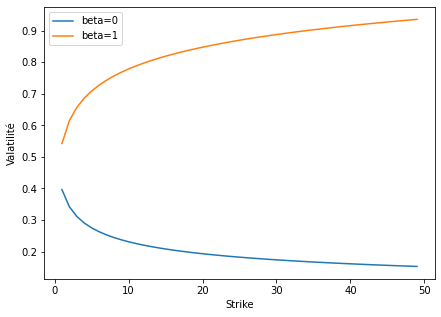

In [178]:
plt.figure(figsize=(7,5))
plt.plot(X,l1)
plt.plot(X,l2)
plt.xlabel('Strike')
plt.ylabel('Valatilité')
plt.legend(["beta=0","beta=1"])
plt.savefig('Volatility-Strike.png')
plt.show()

# Variation en fonction du forward
Les memes paramettre seulement que l'on change la variable

In [180]:
M1=[SABR1(0.005923,0.0,0.180814,0.810425,i,0.01219,1) for i in np.arange(0.01,1,0.01)]
M2=[SABR1(0.005923,1,0.180814,0.810425,i,0.01219,1) for i in np.arange(0.01,1,0.01)]

In [181]:
Y=[i for i in np.arange(0.01,1,0.01)]

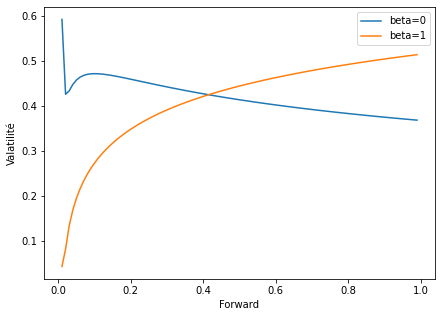

In [182]:
plt.figure(figsize=(7,5))
plt.plot(Y,M1)
plt.plot(Y,M2)
plt.legend(["beta=0","beta=1"])
plt.xlabel('Forward')
plt.ylabel('Valatilité')
plt.savefig('Volatility-forward')
plt.show()

# ATM condition

In [183]:
N1=[SABR1(0.005923,0.0,0.180814,0.810425,i,0.5,1) for i in np.arange(0.01,1,0.01)]
N2=[SABR1(0.005923,1,0.180814,0.810425,i,0.5,1) for i in np.arange(0.01,1,0.01)]

In [184]:
Z=[i for i in np.arange(0.01,1,0.01)]

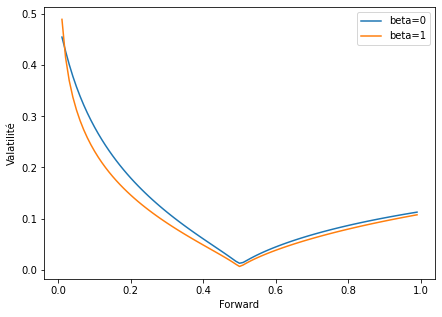

In [185]:
plt.figure(figsize=(7,5))
plt.plot(Z,N1)
plt.plot(Z,N2)
plt.legend(["beta=0","beta=1"])
plt.xlabel('Forward')
plt.ylabel('Valatilité')
plt.savefig('ATM Condition')
plt.show()

[0.0107638332259373,
 0.011099189328091,
 0.0116024287527238,
 0.0121935636676584,
 0.0161959844231264,
 0.0284363638504981,
 0.0338734710965737,
 0.0160174897353125,
 0.0168024601574037,
 0.0176819474963739,
 0.0186232260931809,
 0.0223841862550879,
 0.0305387253564752,
 0.033460206787028,
 0.0229900298619521,
 0.023535063149,
 0.0241191197646149,
 0.0247247202595493,
 0.0271933226970671,
 0.0318835490704834,
 0.0310092021008827,
 0.0263322222163567,
 0.0265494792292252,
 0.0267842607517269,
 0.0270263314132533,
 0.027948737125188,
 0.0292443456593043,
 0.0270809467677389,
 0.025244792841184,
 0.0253993291961977,
 0.0255670295264503,
 0.0257401621025641,
 0.0263998413140275,
 0.0272907584750467,
 0.0259541153585943,
 0.03]